⏳ Cargando dataset con Feature Engineering...
✅ Dataset cargado. Dimensiones: (4425, 61)
Train: 2008-05-12 00:00:00 -> 2022-06-09 00:00:00 | n=3540
Test:  2022-06-10 00:00:00 -> 2025-12-29 00:00:00 | n=885

🌲 Entrenando y Optimizando Random Forest...


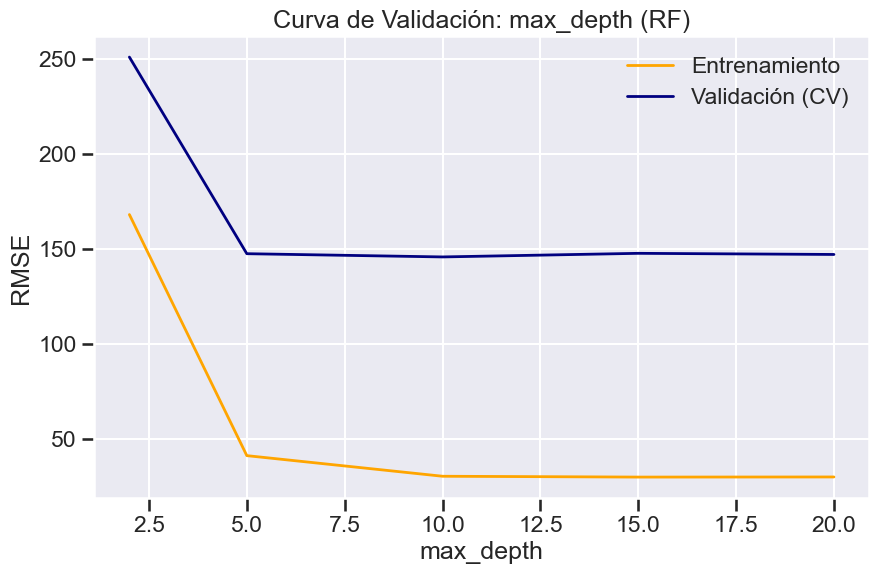

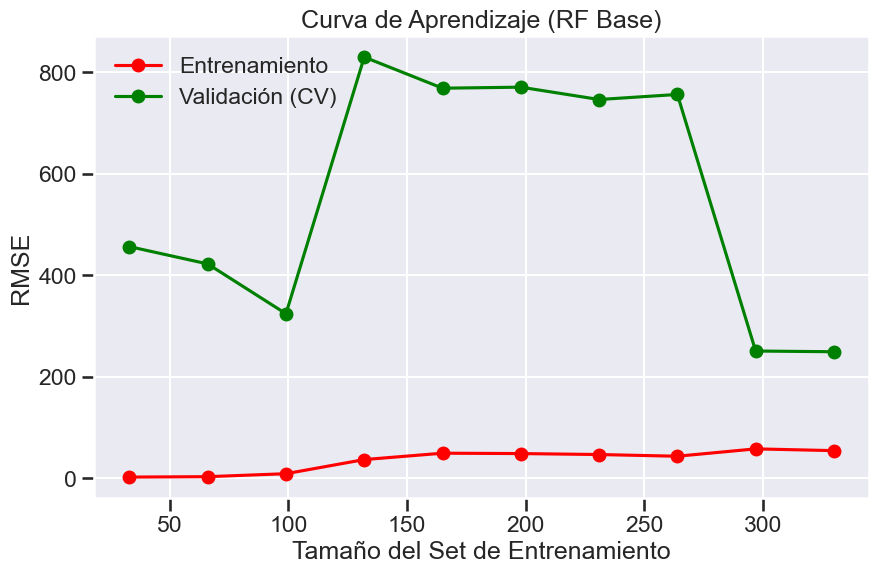

Fitting 10 folds for each of 12 candidates, totalling 120 fits
🏆 Mejor RF: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 300}

🚀 Entrenando y Optimizando XGBoost...
Fitting 10 folds for each of 36 candidates, totalling 360 fits
🏆 Mejor XGB: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}

⚔️ Realizando Test Estadístico (RF vs XGB)...
RMSE promedio por fold (RF):  138.76
RMSE promedio por fold (XGB): 147.36

Resultados Wilcoxon Signed-Rank Test:
Estadístico: 15.0, P-Value: 0.2324
⚠️ No hay diferencia estadísticamente significativa entre modelos.

🧪 INICIANDO ESTUDIO DE ABLACIÓN: ¿Cuánto importa el NLP/Macro realmente?
Re-entrenando el modelo ganador SIN variables de EMBI (ciego al precio pasado)...
Eliminando 6 variables autorregresivas: ['target_embi', 'target_embi_lag1', 'target_embi_lag7', 'target_embi_lag30', 'target_embi_roll_mean7', 'target_embi_roll_mean30']

📊 RESULTADOS FINALES EN TEST (2022-2025):
1. Modelo Completo (Con Lags de Prec

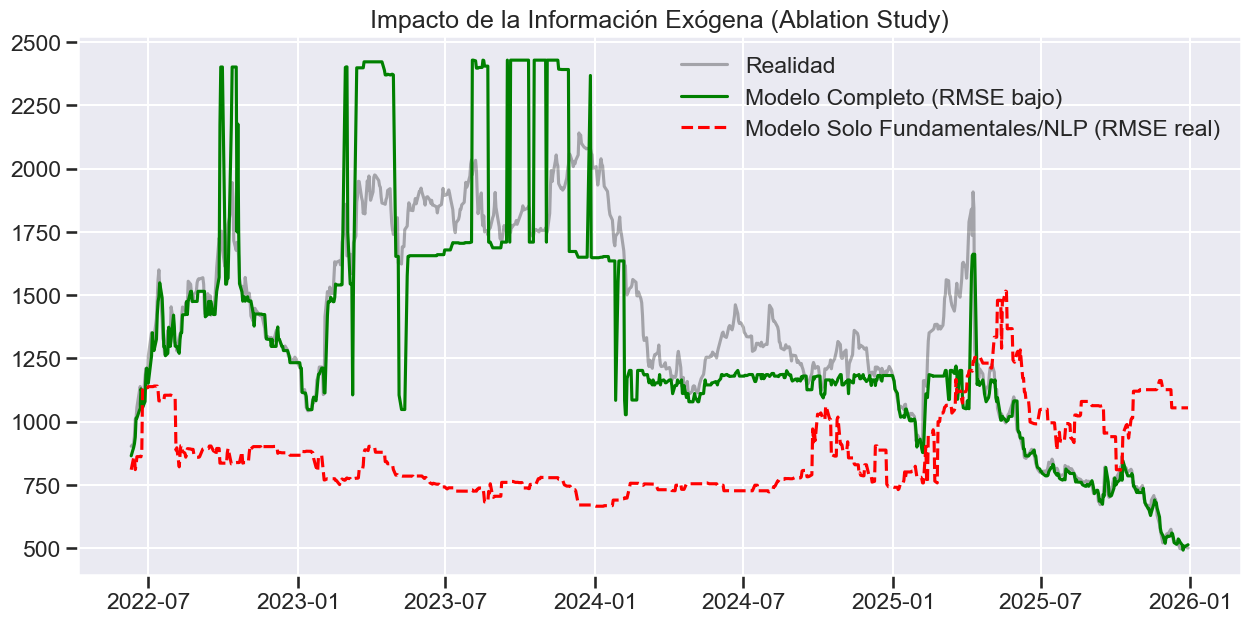

C:\Users\danny\AppData\Local\Temp\ipykernel_18092\4281753385.py:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=imp_df.head(20), palette='magma')


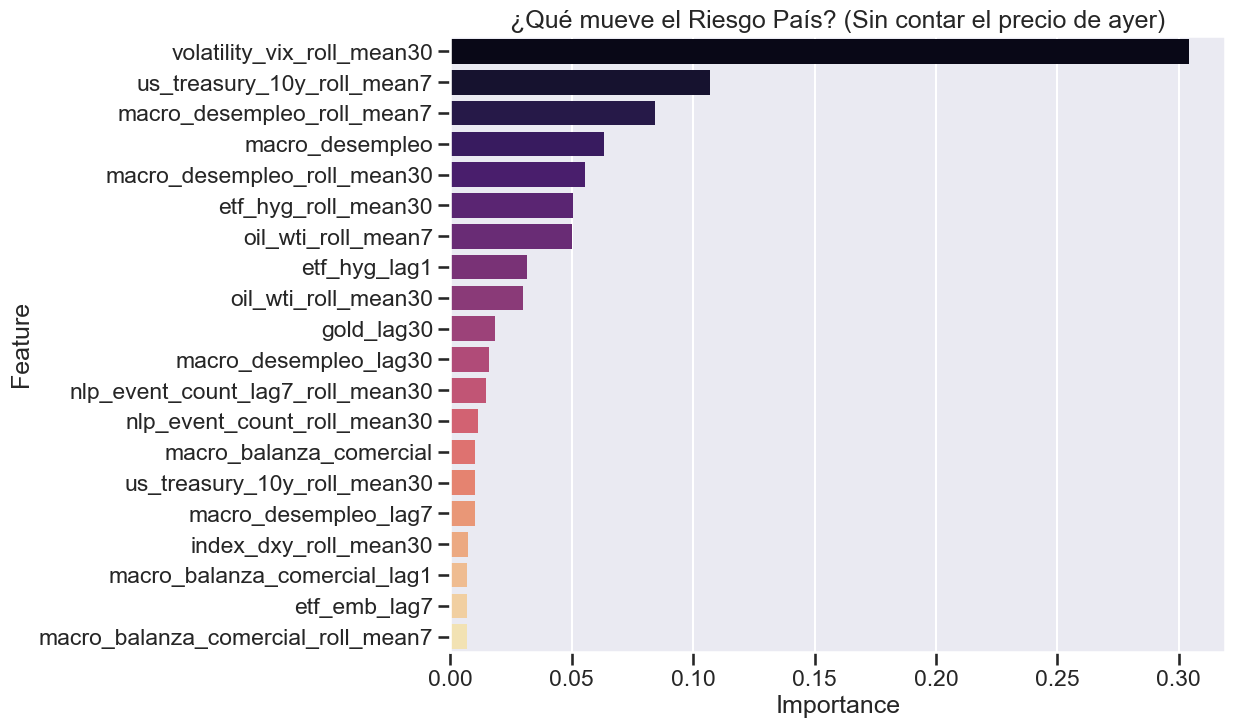

In [1]:
# =============================================================================
# 04_Modelling_ML.ipynb
# =============================================================================
# Objetivo: Modelado Avanzado (RF vs XGB), Optimización, Validación Estadística
#           y Estudio de Ablación (Impacto Real de Variables Exógenas).
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

# Modelos
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Métricas y Validación
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("talk")

# -----------------------------------------------------------------------------
# 1. CARGA Y PREPARACIÓN
# -----------------------------------------------------------------------------
print("⏳ Cargando dataset con Feature Engineering...")
try:
    df = pd.read_pickle('dataset_feature_engineered.pkl')
    print(f"✅ Dataset cargado. Dimensiones: {df.shape}")
except FileNotFoundError:
    print("❌ ERROR: No se encuentra 'dataset_feature_engineered.pkl'. Ejecuta el Notebook 03 primero.")

# Separar X e y
# El target ya está desplazado (t+1) desde el notebook anterior
target_col = 'target_future'
X = df.drop(columns=[target_col])
y = df[target_col]

# Split Cronológico para Evaluación Final (Hold-out)
# Dejamos el último 20% (aprox 2022-2025) para la prueba final "fuera de muestra"
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Train: {X_train.index.min()} -> {X_train.index.max()} | n={len(X_train)}")
print(f"Test:  {X_test.index.min()} -> {X_test.index.max()} | n={len(X_test)}")

# Esquema de Validación Cruzada Temporal (CV) para optimización
# 10 Splits para tener suficientes puntos para el Test de Wilcoxon
tscv = TimeSeriesSplit(n_splits=10)

# -----------------------------------------------------------------------------
# 2. FUNCIONES DE DIAGNÓSTICO (REQUISITO RÚBRICA)
# -----------------------------------------------------------------------------
def plot_optimization_curves(model, X, y, param_name, param_range, title_suffix):
    """Genera Curva de Validación (Optimización de Hiperparámetro)"""
    train_scores, test_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        cv=tscv, scoring="neg_root_mean_squared_error", n_jobs=-1
    )
    
    # Convertir a RMSE positivo
    train_mean = -np.mean(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, label="Entrenamiento", color="orange", lw=2)
    plt.plot(param_range, test_mean, label="Validación (CV)", color="navy", lw=2)
    plt.title(f"Curva de Validación: {param_name} ({title_suffix})")
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.legend(loc="best")
    plt.show()

def plot_learning_curve_viz(model, X, y, title_suffix):
    """Genera Curva de Aprendizaje (Bias vs Variance)"""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=tscv, scoring='neg_root_mean_squared_error',
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = -np.mean(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación (CV)")
    plt.title(f"Curva de Aprendizaje ({title_suffix})")
    plt.xlabel("Tamaño del Set de Entrenamiento")
    plt.ylabel("RMSE")
    plt.legend(loc="best")
    plt.show()

# -----------------------------------------------------------------------------
# 3. MODELO 1: RANDOM FOREST (Optimización y Gráficos)
# -----------------------------------------------------------------------------
print("\n🌲 Entrenando y Optimizando Random Forest...")

# A. Gráficos de Diagnóstico Inicial (para cumplir rúbrica)
# Usamos un modelo base para ver cómo se comporta la profundidad
rf_base = RandomForestRegressor(n_estimators=100, random_state=42)
plot_optimization_curves(rf_base, X_train, y_train, "max_depth", [2, 5, 10, 15, 20], "RF")
plot_learning_curve_viz(rf_base, X_train, y_train, "RF Base")

# B. Grid Search (Optimización Fina)
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 4]
}

rf_grid = GridSearchCV(rf_base, rf_params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print(f"🏆 Mejor RF: {rf_grid.best_params_}")

# -----------------------------------------------------------------------------
# 4. MODELO 2: XGBOOST (Optimización)
# -----------------------------------------------------------------------------
print("\n🚀 Entrenando y Optimizando XGBoost...")

xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# A. Grid Search
xgb_params = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9]
}

xgb_grid = GridSearchCV(xgb_base, xgb_params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

print(f"🏆 Mejor XGB: {xgb_grid.best_params_}")

# -----------------------------------------------------------------------------
# 5. COMPARACIÓN ESTADÍSTICA (WILCOXON TEST)
# -----------------------------------------------------------------------------
print("\n⚔️ Realizando Test Estadístico (RF vs XGB)...")

# Obtenemos los puntajes de error de CADA fold del TimeSeriesSplit
# Esto nos da vectores de errores para comparar
scores_rf = cross_val_score(best_rf, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
scores_xgb = cross_val_score(best_xgb, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

# Convertimos a positivo (RMSE)
scores_rf = -scores_rf
scores_xgb = -scores_xgb

print(f"RMSE promedio por fold (RF):  {np.mean(scores_rf):.2f}")
print(f"RMSE promedio por fold (XGB): {np.mean(scores_xgb):.2f}")

# Test de Wilcoxon
stat, p_value = wilcoxon(scores_rf, scores_xgb)
print(f"\nResultados Wilcoxon Signed-Rank Test:")
print(f"Estadístico: {stat}, P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Diferencia Estadísticamente Significativa (Se rechaza H0).")
    winner = "XGBoost" if np.mean(scores_xgb) < np.mean(scores_rf) else "Random Forest"
    print(f"🥇 El modelo ganador es: {winner}")
else:
    print("⚠️ No hay diferencia estadísticamente significativa entre modelos.")
    winner = "XGBoost" # Por defecto o preferencia

# Seleccionamos el modelo ganador para la fase final
final_model = best_xgb if winner == "XGBoost" else best_rf

# -----------------------------------------------------------------------------
# 6. EXPERIMENTO DE ABLACIÓN (ABLATION STUDY)
# -----------------------------------------------------------------------------
print("\n🧪 INICIANDO ESTUDIO DE ABLACIÓN: ¿Cuánto importa el NLP/Macro realmente?")
print("Re-entrenando el modelo ganador SIN variables de EMBI (ciego al precio pasado)...")

# Identificar columnas que contengan 'target_embi' o derivados
embi_cols = [col for col in X_train.columns if 'target_embi' in col]
print(f"Eliminando {len(embi_cols)} variables autorregresivas: {embi_cols}")

# Crear datasets "Ciegos"
X_train_abl = X_train.drop(columns=embi_cols)
X_test_abl = X_test.drop(columns=embi_cols)

# Re-entrenar modelo (Usamos los mismos mejores parámetros, pero con menos datos)
model_abl = final_model.__class__(**final_model.get_params()) # Clona la estructura y parámetros
model_abl.fit(X_train_abl, y_train)

# Predicciones Finales
# 1. Modelo Completo (Con todo)
y_pred_full = final_model.predict(X_test)
rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_full))

# 2. Modelo Ablación (Sin EMBI)
y_pred_abl = model_abl.predict(X_test_abl)
rmse_abl = np.sqrt(mean_squared_error(y_test, y_pred_abl))

print(f"\n📊 RESULTADOS FINALES EN TEST (2022-2025):")
print(f"1. Modelo Completo (Con Lags de Precio): RMSE = {rmse_full:.2f} bps")
print(f"2. Modelo Ablación (Solo NLP + Macro):   RMSE = {rmse_abl:.2f} bps")

# Interpretación Automática
delta = rmse_abl - rmse_full
print(f"\n💡 INTERPRETACIÓN:")
print(f"Al quitar la memoria del precio, el error sube {delta:.2f} puntos.")
if rmse_abl < 675: # 675 era el Baseline ARIMA
    print("✅ ÉXITO: Incluso sin saber el precio de ayer, el modelo NLP+Macro supera al Baseline ARIMA!")
    print(f"   (RMSE Ablación {rmse_abl:.0f} vs ARIMA 675).")
    print("   ESTO PRUEBA QUE TUS VARIABLES EXÓGENAS TIENEN PODER PREDICTIVO REAL.")
else:
    print("⚠️ El modelo depende fuertemente de la inercia del precio.")

# Gráfico Final de Impacto
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Realidad', color='black', alpha=0.3)
plt.plot(y_test.index, y_pred_full, label='Modelo Completo (RMSE bajo)', color='green')
plt.plot(y_test.index, y_pred_abl, label='Modelo Solo Fundamentales/NLP (RMSE real)', color='red', linestyle='--')
plt.title("Impacto de la Información Exógena (Ablation Study)")
plt.legend()
plt.show()

# Feature Importance del Modelo Ablación (Aquí se verán las News de verdad)
if hasattr(model_abl, 'feature_importances_'):
    importances = model_abl.feature_importances_
    feat_names = X_train_abl.columns
    imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=imp_df.head(20), palette='magma')
    plt.title("¿Qué mueve el Riesgo País? (Sin contar el precio de ayer)")
    plt.show()